In [151]:
import math
from math import radians, degrees
import numpy as np
import casadi
from casadi import sin, cos, atan2, pi
import matplotlib.pyplot as plt
%matplotlib widget

# link lengths of front arm (mm), refer to Jack's IK sketch
a1 = 23.785 #back input link
a2 = 72.253 #shin back
a3 = 35.190 #shin top
a4 = 47.276 #shin forward
a5 = 29.621 #between shin and front input link
a6 = 25.939 #front input link
a7 = 20.200 #between input links
theta7 = radians(34.759) #angle of back input pt to front input pt to world x-axis
theta2 = radians(33.838) #angle between top and back of shin

sin7 = math.sin(theta7) 
cos7 = math.cos(theta7)

theta1_range = [radians(75.8), radians(360-6)]
theta6_range = [radians(-103.1), radians(172.3)]

theta_b_min = radians(47.9)
theta_b_max = radians(169.297)
theta_t_min = radians(23.746)
theta_t_max = radians(174.406)
theta_f_min = radians(49.966)
theta_f_max = radians(142.954)
# theta_i1_min = radians(13.84)

In [152]:
def fk(theta1, theta6, guess=None):
    if(guess == None):
        theta3_guess = radians(-23.3)
        theta5_guess = radians(-166.6)
        sin3_g = sin(theta3_guess)
        cos3_g = cos(theta3_guess)
        sin5_g = sin(theta5_guess)
        cos5_g = cos(theta5_guess)
        guess = [sin3_g, cos3_g, sin5_g, cos5_g]
        
    opti = casadi.Opti()
    sin1 = math.sin(theta1)
    cos1 = math.cos(theta1) 
    sin6 = math.sin(theta6)
    cos6 = math.cos(theta6)

    sin3 = opti.variable()
    cos3 = opti.variable()
    sin5 = opti.variable()
    cos5 = opti.variable()

    opti.set_initial(sin3, guess[0])
    opti.set_initial(cos3, guess[1])
    opti.set_initial(sin5, guess[2])
    opti.set_initial(cos5, guess[3])

    obj = (a1*cos1 + a3*cos3 - (a7*cos7 + a6*cos6 + a5*cos5))**2 + (a1*sin1 + a3*sin3 - (a7*sin7 + a6*sin6 + a5*sin5))**2
    opti.minimize(obj)
    opti.subject_to(sin3**2 + cos3**2 == 1)
    opti.subject_to(sin5**2 + cos5**2 == 1)

    theta3 = atan2(sin3,cos3)

    p1 = (a1*cos1, a1*sin1)
    p2 = (p1[0] + a2*cos(theta3 - theta2), p1[1] + a2*sin(theta3 - theta2))
    p5 = (p1[0] + a3*cos3, p1[1] + a3*sin3)
    p7 = (a7*cos7, a7*sin7)
    p6 = (p7[0] + a6*cos6, p7[1] + a6*sin6)

    neg_cos_theta_b = -cos(atan2(-p1[1], -p1[0]) - atan2(p2[1] - p1[1], p2[0] - p1[0]) - (theta_b_min + theta_b_max)/2)
    neg_cos_theta_t = -cos(-atan2(p7[1]-p6[1], p7[0]-p6[0]) + atan2(p5[1] - p6[1], p5[0] - p6[0]) - (theta_t_min + theta_t_max)/2)
    neg_cos_theta_f = -cos(atan2(p1[1]-p5[1], p1[0]-p5[0]) - atan2(p6[1] - p5[1], p6[0] - p5[0]) - (theta_f_min + theta_f_max)/2)

    opti.subject_to(neg_cos_theta_b <= -cos((theta_b_min - theta_b_max)/2))
    opti.subject_to(neg_cos_theta_t <= -cos((theta_t_min - theta_t_max)/2))
    opti.subject_to(neg_cos_theta_f <= -cos((theta_f_min - theta_f_max)/2))

    p_opts = dict(print_time=False, verbose=False)
    s_opts = dict(print_level=0)
    opti.solver('ipopt', p_opts, s_opts)
    # opti.solver('ipopt')
    # sol = opti.solve()
    try:
        sol = opti.solve()
        return sol.value(p2[0]), sol.value(p2[1]), sol.value(obj)
    except:
        return 0, 0, 999


theta1_n = radians(172)
theta6_n = radians(-40)

fk(theta1_n, theta6_n)

(11.68386880408498, -59.76767212919772, 3.592148750562786e-18)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


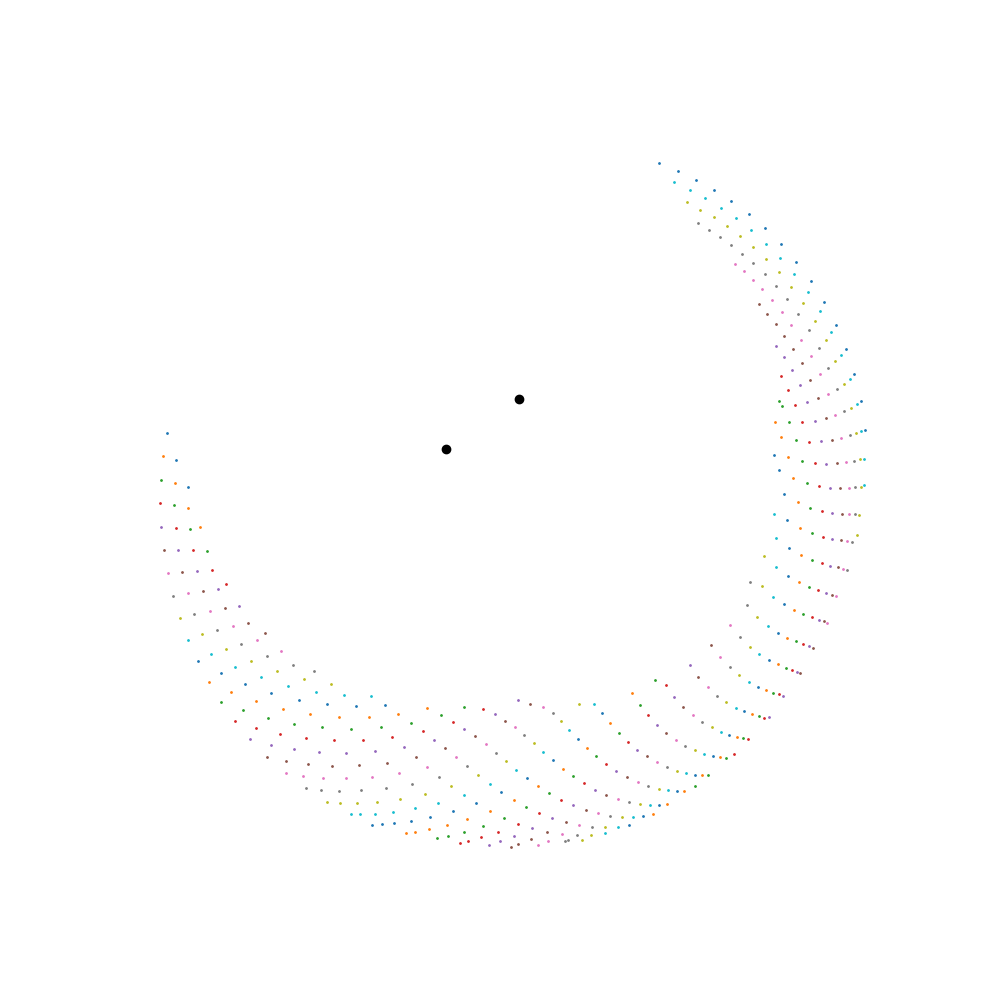

In [158]:
pts_per_line = 40
# grid_spacing = 5

theta1_grid = np.linspace(theta1_range[0], theta1_range[1], pts_per_line+1)
theta6_grid = np.linspace(theta6_range[0], theta6_range[1], pts_per_line+1)

plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal', adjustable='box')
i = 0

workspace = []
for theta1 in theta1_grid:
    theta1s = []
    theta6s = []
    xs = []
    ys = []
    i+=1
    print(i)
    theta6_sweep = []
    for theta6 in theta6_grid:
        p2x, p2y, obj = fk(theta1, theta6)
        if(obj > 1):
            theta1s.append(theta1)
            theta6s.append(theta6)
            xs.append(None)
            ys.append(None)
            continue
        # guess = sol
        theta1s.append(theta1)
        theta6s.append(theta6)
        xs.append(p2x)
        ys.append(p2y)

        if(obj < 1): #solution found
            theta6_sweep.append([p2x,p2y])
        else:
            theta6_sweep.append(None)
        # print(theta1, y)
    workspace.append(theta6_sweep)
    plt.scatter(xs, ys, s=1)
    # plt.scatter(xs, ys, s=1, c=[(0.2, 0.5*(sin(i/5)+1), 0.8)])

plt.scatter(0, 0, color='k')
p7 = (a7*cos(theta7), a7*sin(theta7))
plt.scatter(p7[0], p7[1], color='k')
plt.axis('off')
plt.savefig('armworkspace2.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [171]:
workspace[0]

[[1.3229595730117016, 1.3229595730117016, 1.3229595730117016],
 [-1.7994344588061537, -1.679268539806344, -1.5591026208065346],
 [-63.807221319860034, -61.72202306019193, -59.12753854171929],
 [3.8096812342730004, -2.5658287214945403, -8.571030446498998]]

23


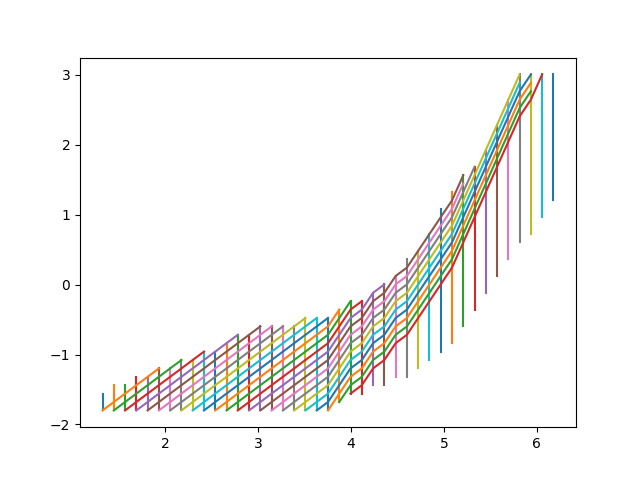

In [198]:
plt.figure()
for i in range(len(workspace)):
    plt.plot(workspace[i][0], workspace[i][1])

n = len(workspace)
diags = []
for i in range(n):
    xs = []
    ys = []
    if(i+j >= n):
        break
    for j in range(n):
        if(j >= len(workspace[i+j][0])):
            break
        xs.append(workspace[i+j][0][j])
        ys.append(workspace[i+j][1][j])
    diags.append((xs, ys))

# xs = []
# ys = []
# for j in range(n):
#     if(j >= len(workspace[j][0])):
#         break
#     xs.append(workspace[j][0][j])
#     ys.append(workspace[j][1][j])
# diags.append((xs, ys))

# xs = []
# ys = []
# for j in range(n):
#     if(j >= len(workspace[1+j][0])):
#         break
#     xs.append(workspace[1+j][0][j])
#     ys.append(workspace[1+j][1][j])
# diags.append((xs, ys))



print(len(diags))

for diag in diags:
    plt.plot(diag[0], diag[1])

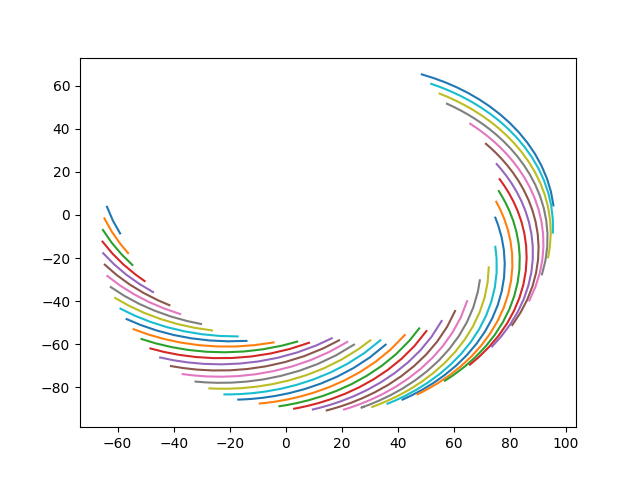

In [160]:
plt.figure()
for i in range(len(workspace)):
    plt.plot(workspace[i][2], workspace[i][3])

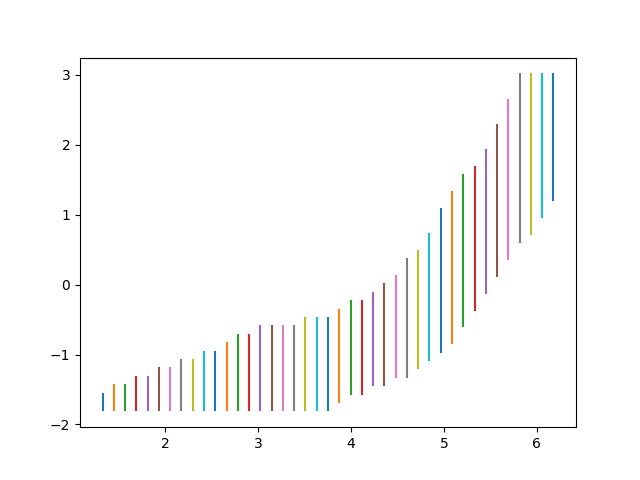

In [162]:
plt.figure()
for i in range(len(workspace)):
    plt.plot(workspace[i][0], workspace[i][1])

In [174]:
workspace

[[[1.3229595730117016, 1.3229595730117016, 1.3229595730117016],
  [-1.7994344588061537, -1.679268539806344, -1.5591026208065346],
  [-63.807221319860034, -61.72202306019193, -59.12753854171929],
  [3.8096812342730004, -2.5658287214945403, -8.571030446498998]],
 [[1.4443472224879073,
   1.4443472224879073,
   1.4443472224879073,
   1.4443472224879073],
  [-1.7994344588061537,
   -1.679268539806344,
   -1.5591026208065346,
   -1.438936701806725],
  [-64.72546104248924,
   -62.12323713104833,
   -59.05101908075849,
   -56.291299162070125],
  [-1.5805704200770414,
   -7.702092800820264,
   -13.421366172388396,
   -17.697602562128928]],
 [[1.5657348719641129,
   1.5657348719641129,
   1.5657348719641129,
   1.5657348719641129],
  [-1.7994344588061537,
   -1.679268539806344,
   -1.5591026208065346,
   -1.438936701806725],
  [-65.24975228778185,
   -62.16536227269405,
   -58.643982339506834,
   -54.755396488163385],
  [-6.992585320154738,
   -12.83471956434629,
   -18.25391787302213,
   -23.2